In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

df = pd.read_csv("ad_spends.csv")

# --- Minimal monthly aggregation ---
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Month'] = df['Transaction_Date'].dt.to_period('M').dt.to_timestamp()

monthly = df.groupby('Month').agg(
    Monthly_Sales=('Revenue', 'sum'),
    Ad_Spend=('Ad_Spend', 'sum'),
    Discount=('Discount_Applied', 'mean'),
    Customer_Footfall=('Clicks', 'sum')
).reset_index()

# --- Model: Linear Regression ---
X = monthly[['Ad_Spend', 'Discount', 'Customer_Footfall']]
y = monthly['Monthly_Sales']
model = LinearRegression()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kfold)
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)

print('Fold RMSE:', np.round(-neg_rmse_scores, 3))
print('Fold R²:', np.round(r2_scores, 3))
print('Average RMSE:', (-neg_rmse_scores).mean())
print('Average R²:', r2_scores.mean())

# Fit on all months
model.fit(X, y)
print('Model trained on monthly aggregates!')


Fold RMSE: [185454.302 118238.903  51024.503  49618.616 109044.16 ]
Fold R²: [ 0.844  0.327  0.999  0.753 -4.769]
Average RMSE: 102676.09717250957
Average R²: -0.36918798302538625
Model trained on monthly aggregates!


In [2]:
df.head()

,Transaction_ID,Customer_ID,Product_ID,Transaction_Date,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Category,Region,Ad_CTR,Ad_CPC,Ad_Spend,Month
0,8b460852-7c64-46fa-998b-b0976879d082,Customer_65,Product_224,2024-10-06,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55,9.90,2024-10-01
1,418612e7-8744-4ba3-bb0c-105b47e2a968,Customer_1910,Product_584,2024-10-29,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40,63.56,2024-10-01
2,5bc3b98f-cb0c-4b12-947c-df8bbb35a73e,Customer_2306,Product_374,2024-04-04,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50,89.40,2024-04-01
3,28fb67c8-e8c0-447a-841c-f760730de0eb,Customer_17206,Product_220,2024-08-25,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44,19.54,2024-08-01
4,8bee087a-a8a9-45bb-89d7-04d1710f1b00,Customer_16033,Product_358,2024-05-05,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53,67.31,2024-05-01


In [3]:
monthly.head()

,Month,Monthly_Sales,Ad_Spend,Discount,Customer_Footfall
0,2023-12-01,3723069.77,744453.01,0.150517,166212
1,2024-01-01,4665609.02,937174.99,0.151241,207031
2,2024-02-01,4312157.04,864081.10,0.148196,191377
3,2024-03-01,4705422.31,958465.17,0.149558,208856
4,2024-04-01,4406829.73,885693.50,0.149769,200198


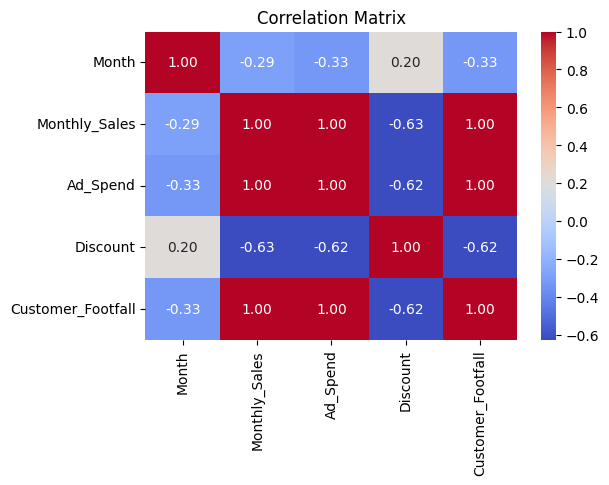

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Correlation Matrix -----
plt.figure(figsize=(6,4))
#corr = monthly[["Monthly_Sales", "Ad_Spend", "Discount", "Customer_Footfall"]].corr()
sns.heatmap(monthly.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



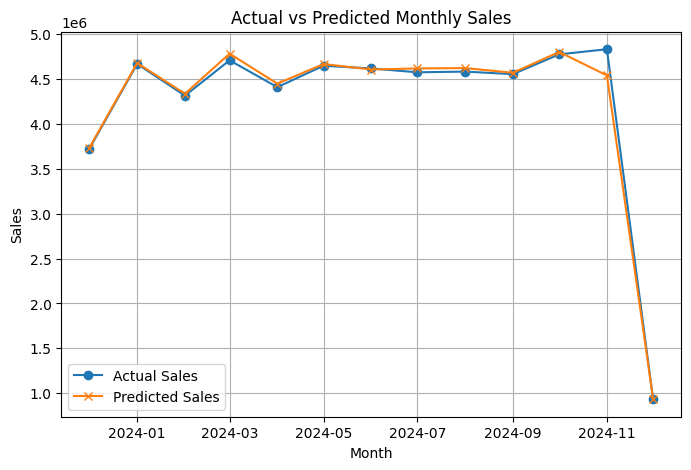

In [5]:

# ----- Actual vs Predicted Chart -----
y_pred = model.predict(X)

plt.figure(figsize=(8,5))
plt.plot(monthly["Month"], y, label="Actual Sales", marker='o')
plt.plot(monthly["Month"], y_pred, label="Predicted Sales", marker='x')
plt.title("Actual vs Predicted Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()